<h1><center>Text Translator with Seq2Seq models and Attention mechanism</center></h1>

The evolution of language translation using machine learning can be traced back to the 50s, when researchers began experimenting with rule-based systems to automatically translate languages. These foundational systems relied on sets of hand-coded rules and dictionaries to translate text.


<h1>1. Introduction</h1>

In the 1990s, statistical machine translation (SMT) became popular. SMT systems used statistical models to learn how words and phrases in one language correspond to words and phrases in another language. These systems required large amounts of bilingual data and were limited by their <strong>inability</strong> to capture the <strong>meaning</strong> and <strong>context</strong> of a sentence.

In the early 2010s, neural machine translation (NMT) emerged as a breakthrough in machine translation. NMT systems use artificial neural networks to model the relationships between words and phrases in different languages. NMT models can capture complex language structures and are able to produce more fluent and accurate translations than SMT systems.

In recent years, transformer-based architectures like the GPT (Generative Pre-trained Transformer) and BERT (Bidirectional Encoder Representations from Transformers) have shown great success in natural language processing (NLP), including language translation. These models are trained on massive amounts of data and can capture complex patterns in language, leading to highly accurate translations.

Overall, machine translation has made significant progress over the past few decades, with NMT and transformer-based models showing great promise for accurate and fluent translations.

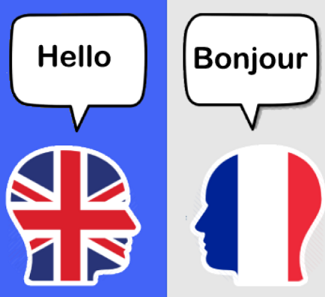

In this project we will run trough a neural network architecture to translate from French to English

We will combine two Learning Techniques to achieve our target:
* The idea of Sequence to Sequence Network
* The Attention mechanism

<h3> Sequence to Sequence network</h3>

A sequence-to-sequence <strong>(Seq2Seq)</strong> model is a type of neural network architecture used for tasks such as language translation, text summarization, and speech recognition.

The Seq2Seq model consists of two parts: an encoder and a decoder.

The <strong>encoder</strong> takes in a sequence of input data, such as a sentence in one language, and produces a fixed-length vector representation of that input. This vector is called the <strong>"context vector"</strong> and it summarizes the important information from the input sequence.

The <strong>decoder</strong> takes the context vector and uses it to generate a sequence of output data, such as a translation of the input sentence in another language. The decoder generates each output element one at a time, taking in the previous element as input, until the entire output sequence is generated.

During training, the model is trained to minimize the difference between the predicted output sequence and the actual output sequence, using a measure such as cross-entropy loss. The model is trained using pairs of input and output sequences, and the weights of the model are updated iteratively to improve its accuracy.

The Seq2Seq model is a powerful and flexible architecture for sequence-based tasks, and has been used successfully for a variety of applications in natural language processing and speech recognition.


You can check out all the details in the following paper [sequence to sequence network](https://arxiv.org/abs/1409.3215)

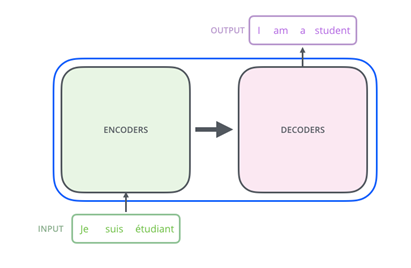

<h3>Attention Mechanism</h3>

The attention mechanism is a technique used in machine learning to improve the performance of sequence-based models such as recurrent neural networks (RNNs) and transformers. The basic idea behind attention is to allow the model to selectively focus on different parts of the input sequence when making predictions.

In a sequence-based model, each element of the input sequence is typically processed independently, with no information shared between them. However, in many cases, it is important for the model to take into account the entire sequence when making predictions. This is where attention comes in.

The attention mechanism works by computing a set of attention weights for each element of the input sequence. These weights indicate how much attention the model should pay to each element when making predictions. The attention weights are computed based on the similarity between the current state of the model and each element of the input sequence.

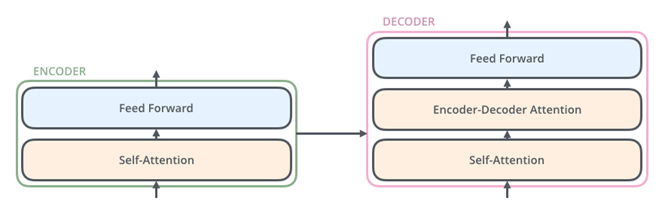

During training, the attention weights are learned along with the other parameters of the model, using backpropagation and gradient descent. During inference, the attention weights are computed based on the current state of the model and the entire input sequence, and used to weight the contributions of each element of the sequence when making predictions.

Overall, the attention mechanism has been shown to improve the performance of sequence-based models on a variety of tasks, including language translation, text classification, and speech recognition. It allows the model to selectively focus on the most relevant parts of the input sequence, leading to more accurate and efficient predictions.

You can check out all the details in the following paper [attention
mechanism](https://arxiv.org/abs/1409.0473)

It's worth remarking that the paper attached above is not the state-of-the-art in Attention Mechanisms. You can learn how the latest attention mechanism works in the paper [Attention is all you need](https://arxiv.org/abs/1706.03762.pdf)


Let's start off with our language translation project

<h1>2. Importing modules</h2>

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
from IPython.display import Video
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Configure a GPU if it exists. If not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline


<h1>3. Preparing data</h1>

The data for this project is a set of many thousands of English to
French translation pairs.


The English to French pairs are too saved ``data/traductor/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:



    I am cold.    J'ai froid.

Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word).

Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

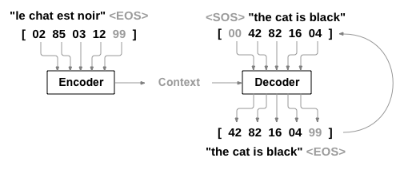

We'll need a unique index per word to use as the inputs and targets for the neural networks. 

To keep track of all this we will use a helper class called ``Lang`` which has word → index (``word2index``) and index → word (``index2word``) dictionaries, as well as a count of each word ``word2count`` which will be used to replace rare words later.


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

<strong>Exercise 1</strong>: Check out the effect of the function defined above in a string with non ASCII characters.

In [4]:
string = "Yáñez"

### Your code starts here ###

### Your code ends here ###

print("The string {0:s} is converted to {1:s}".format(string,unicoded))

The string Yáñez is converted to Yanez


The following function converts all letters to lowercase, trims, and removes non-letter characters

In [5]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

<strong>Exercise 2</strong>: Convert the string given below to ASCII, then normalize it.
    
    

In [6]:
string = "Normalïzing texts is# key to gët models with hîgh perfomance"

### Your code starts here ###

### Your code ends here ###

print("The string has been converted to: {0:s}".format(normalized))

The string has been converted to: normalizing texts is key to get models with high perfomance


<strong>Exercise 3</strong>: Initialize a Lang class with 'eng' Language.

In [7]:
### Your code starts here ###



###Your code ends here ###

<strong>Exercise 4</strong>: Add the sentence you've normalized in Exercise 2.

In [8]:
### Your code starts here ###



###Your code ends here ###

<strong>Exercise 5</strong>: Print the dictionary generated by Lang class where the key is the index of the word in the dictionary and the item is the word itself

In [9]:
### Your code starts here ###


###Your code ends here ###

{0: 'SOS',
 1: 'EOS',
 2: 'normalizing',
 3: 'texts',
 4: 'is',
 5: 'key',
 6: 'to',
 7: 'get',
 8: 'models',
 9: 'with',
 10: 'high',
 11: 'perfomance'}

<strong>Exercise 6</strong>: Print the dictionary generated by Lang class where the key is each word of the sentence and the item is the index of the word in the dictionary. Why doesn't the first word of the sentence have index '0' in the dictionary?

In [10]:
### Your code starts here ###



###Your code ends here ###

{'normalizing': 2,
 'texts': 3,
 'is': 4,
 'key': 5,
 'to': 6,
 'get': 7,
 'models': 8,
 'with': 9,
 'high': 10,
 'perfomance': 11}

To read the data file we will do the follwoing
1. split the file into lines, 
2. split lines into pairs. 

The files are all English → Other Language

If you want to translate from other Language to English, activate the ``reverse`` flag to reverse the pairs.


In [11]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/traductor/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [12]:
input_lang, output_lang, pairs = readLangs('eng', 'fra', True)

Reading lines...


<strong>Exercise 7</strong>: Print the 550th sentence of the input language.

In [13]:
### Your code starts here ###



###Your code ends here ###

'je me suis eveille .'

Since the dataset is too large and it has a lot of examples, we'll generate a function to trim the dataset according to the number of words it contains. We will only keep sentences starting with a pronoun and the verb "to be" in the present tense.

In [14]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs


In [15]:
del input_lang, output_lang

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, _pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(_pairs))
    f_pairs = filterPairs(_pairs)
    print("Trimmed to %s sentence pairs" % len(_pairs))
    print("Counting words...")
    for pair in f_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, f_pairs


input_lang, output_lang, trim_pairs = prepareData('eng', 'fra', True)
print(random.choice(trim_pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 135842 sentence pairs
Counting words...
Counted words:
fra 5750
eng 3786
['je recois une allocation mensuelle de cinquante mille yens .', 'i am given a monthly allowance of fifty thousand yen .']


<strong>Exercise 8</strong>: Choose randomly a pair a print it.

In [16]:
### Your code starts here ###



### Your code ends here ### 

['je vais avoir besoin de plus d argent .', 'i m going to need some more money .']


<h2>Building Tensors from data</h2>

You're realizing everthing we've done is just a way to convert human language to some kind of numbers that a machine can understand... But there is one step more. Bear in mind that Pytorch models are fed with Tensors, therefore we will convert to tensor all the work we've done so far.

To train, for each pair we will need the following:
* an input tensor 
* a target tensor, it will be the label o ground truth of the model.

To do so, we define a function that returns the input tensor and the target tensor. Each tensor will have the indexes of the words that compose the sentence

While creating these vectors we will append the EOS token to both sequences.

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

<strong>Exercise 9</strong>: Convert the pair of sentences at index 1000 from the English-French sentence file to tensors. Also print the size of the input tensor and the target tensor as well.

In [18]:
### Your code starts here ###



###Your code ends here ###

print ("The size of the input tensor is {0:s}".format(str(input_tensor.size())))
print ("The size of the target tensor is {0:s}".format(str(target_tensor.size())))

The size of the input tensor is torch.Size([5, 1])
The size of the target tensor is torch.Size([5, 1])


<h1>4. The Seq2Seq Model</h1>

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model <strong>frees us from sequence
length and order</strong>, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




Run the following cell to watch an animation of a sequence to sequence model...

In [1]:
%%HTML
<div align="center"> 
    <video width="320" height="240" controls>
      <source src="./images/seq2seq_5.mp4" type="video/mp4">
    </video>
</div>

<h2> The Encoder</h2>

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

The architecture uses Gated Recurrent Units (GRU), which are like Long Short-Term Memory (LSTM) cells but with a forget gate, thus it has fewer parameters.


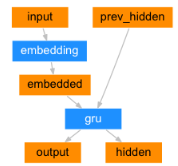

In [22]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<strong>Exercise 10</strong>: Plug an element of a tensor in the EncoderRNN and print the size of the outputs. You can choose the tensor you want. We've previously prepared one...

In [23]:
### Your code starts here ###


### Your code ends here ###

print('Output tensor size: {0:s}'.format(str(output.size())))
print('Hidden tensor size: {0:s}'.format(str(hidden.size())))

Output tensor size: torch.Size([1, 1, 128])
Hidden tensor size: torch.Size([1, 1, 128])


<h2> The Decoder</h2>

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.

<h3> Simple Decoder</h3>

In the simplest seq2seq decoder we use only the last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).



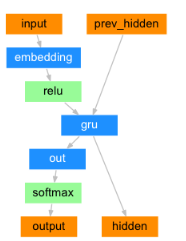

In [40]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<strong>Exercise 11</strong>: Plug in the output of the encoder to the decoder, print the output of the decoder

Hint: read trough the simple encoder definition, you will realize that before plugging in anything, you have to intialize the input. We provide the decoder input intialization for you

In [41]:
init_decoder_input = torch.tensor([[SOS_token]], device=device)

In [44]:
### Your code starts here ###


### Your code ends here ###

print('Output tensor size: {0:s}'.format(str(decoder_output)))

Output tensor size: tensor([[-8.3022, -8.2088, -8.2651,  ..., -8.1569, -8.4452, -8.2108]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


Of course, the Decoder doesn't get any useful information. Firstly, you need to train the model to check if it can translate properly

<h3> Attention Decoder</h3>

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

<strong>Attention</strong> mechanism allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. 

First we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.





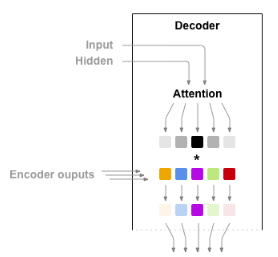

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

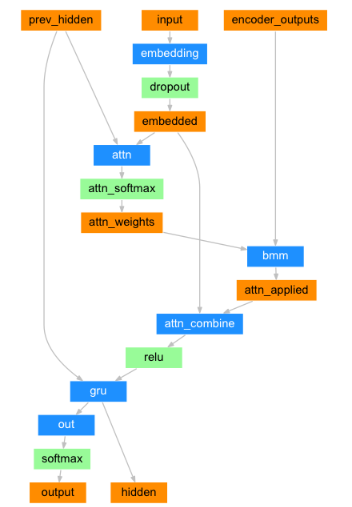

In [45]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

These models are not a piece of cake. Now you are starting to address real world models used for many real world projects. 

<div class="alert alert-info"><h4>Note</h4>
    <p>There are other forms of attention that work around the length
           limitation by using a relative position approach. Read about "local attention" in <a href="https://arxiv.org/abs/1508.04025">Effective Approaches to Attention-based Neural Machine Translation</a>
    </p>
</div>

<h1> 5. Training phase </h1>

<h2>Training the Model</h2>

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

<h4>Teacher forcing </h4>

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.

Using teacher forcing causes it to converge faster but [when the trained network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




Let's put all the pieces together in the train function.

<strong>Exercise 12</strong>: Multiple exercise. Fill in the gaps requested in the train function

In [60]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    # 12.1 Initialize the optimizer with the method zero_grad
    ### Your code starts here
    
    ### Your code ends here

    # 12.2 Define the variables input_length and output_length as previously done
    ### Your code starts here
    
    ### Your code ends here
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # 12.3 Write down the forward pass for the encoder
        ### Your code starts here
        # encoder_output, encoder_hidden = 
        ### Your code ends here
        encoder_outputs[ei] = encoder_output[0, 0]

    # 12.4 Initialize the decoder input (he've done previously)
    ### Your code starts here
    # decoder_input = 
    ### Your code ends here
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # 12.5 Implement the forward step for the decoder 
            ### Your code starts here
            # decoder_output, decoder_hidden, decoder_attention = 
            ### Your code ends here
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # 12.6 Implement the forward step for the decoder 
            ### Your code starts here
            # decoder_output, decoder_hidden, decoder_attention = 
            ### Your code ends here
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # 12.7 Implement the backward step
    ### Your code starts here
    
    ### Your code ends here

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [61]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




<strong>Exercise 13</strong>: Multiple exercise. Fill in the gaps requested.

In [62]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # 13.1 Choose the loss function ... wich function should you choose?
    ### Your code starts here
    # criterion = 
    ### Your code ends here
    
    # 13.2 Choose the optimization algorithm ... 
    ### Your code starts here
    # encoder_optimizer = 
    # decoder_optimizer = 
    ### Your code ends here
    
    training_pairs = [tensorsFromPair(random.choice(trim_pairs))
                      for i in range(n_iters)]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [63]:
import matplotlib
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
# matplotlib.use('TkAgg')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for later display.


In [64]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [65]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(trim_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

<h2>Training and Evaluating</h2>

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.





<div class="alert alert-info">
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.
</div>

<strong>Exercise 14</strong>: Use the class EncoderRNN to define your encoder, send it to the GPU

In [66]:
### Your code starts here

# hidden_size=
# my_encoder = 

### Your code ends here

<strong>Exercise 15</strong>: Use whether DecodderRNN or AttnDecoderRNN to define your decoder, send it to the GPU

In [67]:
### Your code starts here

# my_decoder = 

### Your code ends here

<strong>Exercise 16</strong>: Call the trainIters function to do the training. Dont't forget to define the main hyperparameters:
* Learning rate
* Number of epochs (called n_iters in this code)
* The size of the hidden vector

2m 26s (- 0m 0s) (5000 100%) 3.1729


<Figure size 640x480 with 0 Axes>

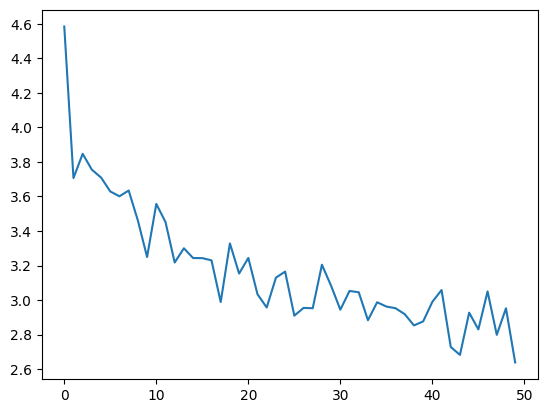

In [68]:
### Your code starts here


### Your code ends here

<strong>Exercise 17</strong>: Use the evaluateRandomly function  to check out how the Seq2Seq model performs

In [69]:
### Your code starts here



### Your code ends here

> nous sommes a la recherche d un endroit ou sejourner .
= we are looking for a place to stay .
< we re the only to . . . . . <EOS>

> tu m as manque .
= i missed you .
< you re the one . <EOS>

> il est juste derriere vous .
= he s right behind you .
< he s you you . <EOS>

> vous etes un chic type .
= you are a good person .
< you re the a . . . . <EOS>

> je suis ici pour une autre raison .
= i m here for another reason .
< i m a for a . . . . <EOS>

> nous sommes pieges .
= we re trapped .
< we re all . <EOS>

> je viens de bulgarie .
= i m from bulgaria .
< i m a for . . <EOS>

> tu es tout ce que j ai .
= you re all i ve got .
< you re the than i . <EOS>

> j ai du rever .
= i must have been dreaming .
< i m a . . . . <EOS>

> nous changeons de vetements .
= we are changing our clothes .
< we re all . . <EOS>



<h2> Visualizing Attention</h2>

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine it as looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




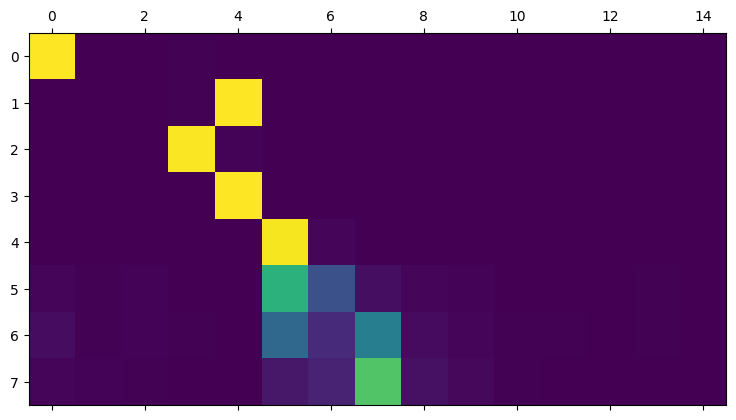

In [70]:
output_words, attentions = evaluate(
    my_encoder, my_decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [73]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    input_sentence = input_sentence.split(' ') + ['<EOS>']
    output_words = [''] + output_words
    ax.set_xticks(range(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=90)
    ax.set_yticks(range(len(output_words)))
    ax.set_yticklabels(output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        my_encoder, my_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


<strong>Exercise 18</strong>: Use the evaluateAndShowAttention function defined abouve to transalte your own Frech sentence and think on the matrix shown by matplotlib

input = elle a cinq ans de moins que moi .
output = she s at to her . . . <EOS>


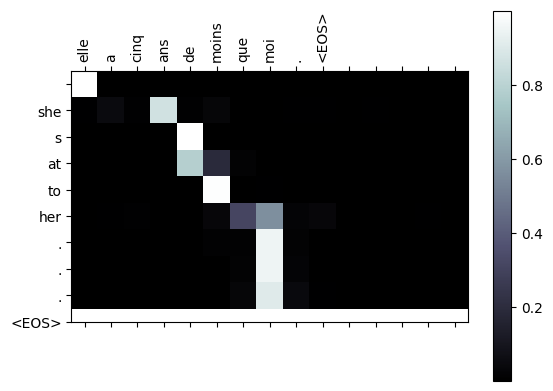

input = elle est trop petit .
output = she s a . . . . <EOS>


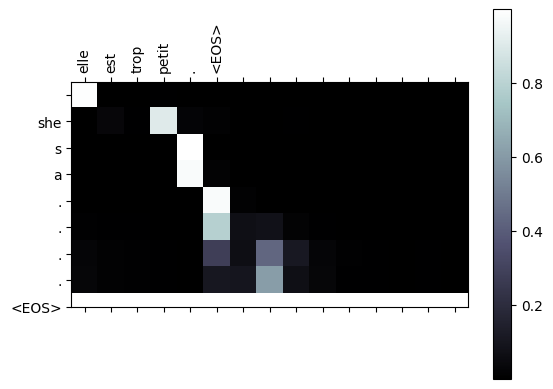

input = je ne crains pas de mourir .
output = i m not your your . . <EOS>


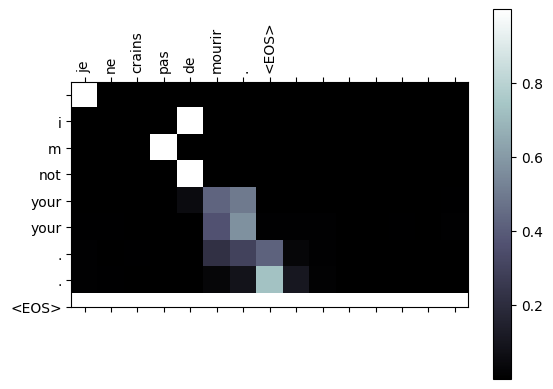

input = c est un jeune directeur plein de talent .
output = he s a a . . . . . <EOS>


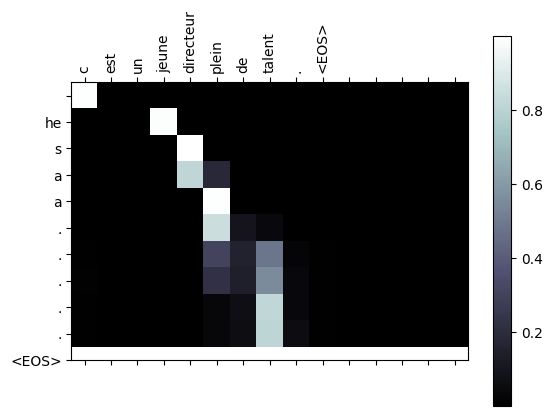

In [74]:
### Your code starts here

### Your code ends here

<strong>Exercise 19</strong>: Try with more epochs, layers, more hidden units, and more sentences. Compare
   the training time and results, or maybe you dare to include more encoder-decoder cascading layers...

<strong>Exercise 20</strong>: Try another dataset. I've prepared for you an English-Spanish set of sentences. How does the model perform with another language?


<strong>Exercise 21</strong>: Did you have fun with the English-Spanish dataset? I attach the link with many other datasets. Maybe you want to build an English-Russian translator model!

Link here: [Tatoeba Project](https://www.manythings.org/anki/)